In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import multiclass
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score ,confusion_matrix
import matplotlib.pyplot as plt




Učitavanje predprocesiranih podataka.

In [2]:
news = pd.read_csv('data/vesti.csv')
news.info()
news.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198627 entries, 0 to 198626
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  198627 non-null  int64 
 1   text        198626 non-null  object
 2   category    198627 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.5+ MB


,Unnamed: 0,text,category
0,36290,shall overcomb say march trump london thousand...,WOMEN
1,21194,bone didnt teach glamour taught respect oftent...,HEALTHY LIVING
2,29672,im sorrythe two tragically forgotten word cust...,BUSINESS
3,199048,divorce ruin life child blame sunday night luc...,DIVORCE
4,193783,well sit civilian flea theater civilian enterp...,DIVORCE


Binarnu klasifikaciju izvodimo nad dve najbrojnije kategorije.

In [3]:
category = ['POLITICS' , 'WELLNESS']
news = news[news.category.isin(category)]

In [4]:

news.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50281 entries, 11 to 198618
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50281 non-null  int64 
 1   text        50281 non-null  object
 2   category    50281 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [5]:
X = news['text']
y = news['category']


In [6]:
X_train_and_validation, X_test, y_train_and_validation, y_test = model_selection.\
    train_test_split(X, y, test_size = 0.33, stratify = y, random_state = 4)

In [7]:
tfidf_vectorizer = feature_extraction.text.TfidfVectorizer()
tfidf_vectorizer.fit(X_train_and_validation.values.astype('U'))

TfidfVectorizer()

In [8]:
X_train_and_validation = tfidf_vectorizer.transform(X_train_and_validation.values.astype('U'))
X_test = tfidf_vectorizer.transform(X_test.values.astype('U'))
y_train_and_validation = y_train_and_validation.astype('category')
y_test = y_test.astype('category')
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X_train_and_validation,\
y_train_and_validation, train_size = 0.8, random_state = 4, stratify = y_train_and_validation )

In [9]:
classes = dict(enumerate(y_train.cat.categories))
y_validation = y_validation.cat.codes
y_train = y_train.cat.codes
y_test = y_test.cat.codes

Logistička regresija je testirana sa dva rešavača gde prvi koristi l2 a drugi l1 normu. Nešto bolji rezultati ostvaruju se u prvom slučaju.

In [10]:
model = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_test_predicted = model.predict(X_test)

In [11]:
acc=metrics.accuracy_score(y_test, y_test_predicted)
f1=metrics.f1_score(y_test, y_test_predicted)
matrix=metrics.confusion_matrix(y_test, y_test_predicted)

print('Najbolji rezultat na test skupu je: ',acc)
print('Matrica konfuzije:\n ', matrix)
print('F1 ', f1)


Najbolji rezultat na test skupu je:  0.9785451696498524
Matrica konfuzije:
  [[10597   151]
 [  205  5640]]
F1  0.9694052939154348


In [12]:
model = linear_model.LogisticRegression(solver='saga', max_iter=1000, penalty='l1')
model.fit(X_train, y_train)
y_test_predicted = model.predict(X_test)

In [13]:
acc=metrics.accuracy_score(y_test, y_test_predicted)
f1=metrics.f1_score(y_test, y_test_predicted)
matrix=metrics.confusion_matrix(y_test, y_test_predicted)

print('Najbolji rezultat na test skupu je: ',acc)
print('Matrica konfuzije:\n ', matrix)
print('F1 ', f1)


Najbolji rezultat na test skupu je:  0.9687217501355994
Matrica konfuzije:
  [[10490   258]
 [  261  5584]]
F1  0.9555916830666551


Bajesov model daje najbolje rezultate za parametar 0.2 i predstavlja najbolji model od svih testiranih modela.

In [14]:
alphas=[0.005,0.006,0.007,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
best_acc=0
best_alpha=None
bayesArray=[]
for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_validation)
    accuracy = accuracy_score(y_validation,y_predict)
    bayesArray.append(accuracy)
    if accuracy> best_acc:
        best_acc = accuracy
        best_alpha = alpha
print('Najbolja preciznost na test skupu je: ', best_acc)
print('Najbolji alfa parametar modela su: ', best_alpha)

Najbolja preciznost na test skupu je:  0.9826357969723953
Najbolji alfa parametar modela su:  0.2


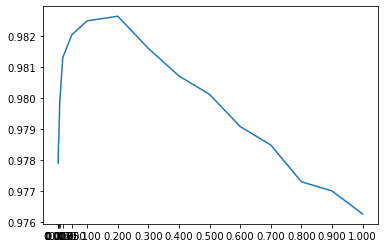

In [15]:
plt.plot(alphas,bayesArray)
plt.xticks(alphas)
plt.show()

U slučaju binarne klasifikacije najbolji parametar je 11. Na ovom modelu primećujemo da neparan broj suseda vrši bolju klasifikaciju nego paran. 

In [16]:
n_neighbors_list=list(range(1, 21))
best_acc_test=0
best_acc_train=0
best_n=None
knnArray=[]
for n_neighbors in n_neighbors_list:
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(X_train, y_train)
    y_predict = knn_model.predict(X_validation)
    accuracy_test = accuracy_score(y_validation,y_predict)
    knnArray.append(accuracy_test)
  #  accuracy_train = knn_model.score(X_train, y_train)
    if accuracy_test> best_acc_test:
        best_acc_test = accuracy_test
   #     best_acc_train=accuracy_train
        best_n = n_neighbors
print('Najbolji rezultat na test skupu je: ',best_acc_test)
print('Najbolji parametri modela su: ', best_n)

Najbolji rezultat na test skupu je:  0.9639358860195903
Najbolji parametri modela su:  11


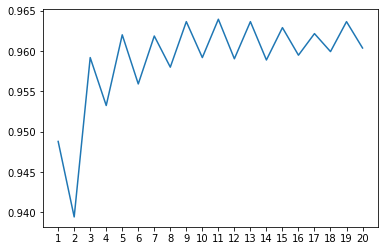

In [17]:
plt.plot(n_neighbors_list,knnArray)
plt.xticks(n_neighbors_list)
plt.show()


In [18]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=best_n)
knn_model.fit(X_train, y_train)
y_predict = knn_model.predict(X_test)

acc=metrics.accuracy_score(y_test, y_predict)
f1=metrics.f1_score(y_test, y_predict)
matrix=metrics.confusion_matrix(y_test, y_predict)

print('Najbolji rezultat na test skupu je: ',acc)
print('Matrica konfuzije:\n ', matrix)
print('F1 ', f1)

Najbolji rezultat na test skupu je:  0.9669740251913458
Matrica konfuzije:
  [[10608   140]
 [  408  5437]]
F1  0.9520224128874103
